## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Черницин Игорь Александрович

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

/home/inact1ve/.local/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


## Описание задания:
Вам необходимо реализовать оставшиеся методы из лекции и сравнить их на примере из семинара.

## Задание разделено на следующие части:
1. Реализация Xavier **(1 балл)**

2.1 Реализация DropConnect **(1 балл)**

2.2 Сравнение обучения при использовании Dropout и DropConnect **(1 балл)**

3.1 Реализация LayerNorm **(1 балл)**

3.2 Сравнение обучения при использовании BatchNorm и LayerNorm **(1 балл)**

## Срок выполнения задания:
Данное задание можно сдать без штрафов до 26 февраля.


### Часть 1: Инициализация весов

Будем использовать MNIST для обучения:

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

100%|██████████████████████████████████████████████████████████████████| 9912422/9912422 [00:00<00:00, 12290808.18it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 42134154.37it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|███████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 1697064.64it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 12950733.36it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [3]:
images_train, labels_train = next(iter(train_loader))

In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    break

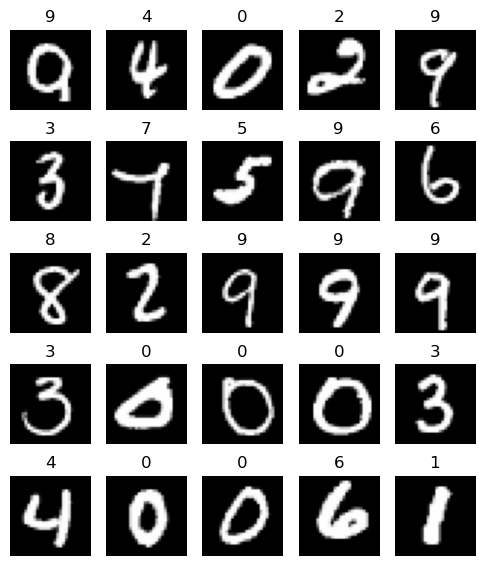

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

In [6]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

На вход передаем изображение 28x28, на выходе -- вероятности 10 классов.

In [7]:
layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

init_layer(layer_1)
init_layer(layer_2)

Соберем все вместе, используя ReLU в качестве функции активации:

In [8]:
network = nn.Sequential(
    layer_1,
    nn.ReLU(),
    layer_2
)

#### 1.1 Реализуйте инициализацию Xavier. Сравните ее с He, которая была реализована на семинаре, сделайте выводы. Учтите, что для Xavier необходимо использовать функцию активации nn.Tanh(). **(1 балл)**

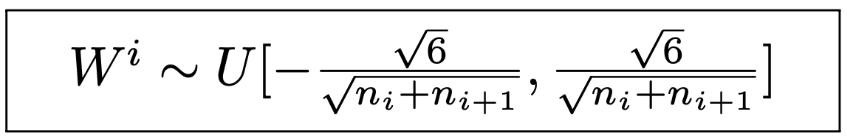

In [17]:
def init_layer_xavier(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    n = layer.in_features + layer.out_features + 1
    limit = (6**0.5/ n**0.5) 
    with torch.no_grad():
        layer.weight.uniform_(-limit, limit)

In [18]:
layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

init_layer_xavier(layer_1)
init_layer_xavier(layer_2)

In [19]:
network = nn.Sequential(
    layer_1,
    nn.Tanh(),
    layer_2
)

Попробуем использовать аналогично с семинаром

In [24]:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss = loss_fn(activations, y)
loss.backward()

forward 0.9673628211021423
forward 0.6413123607635498
backward 0.027080127969384193
backward 0.01263823825865984


He, реализованная на семинаре имела результат на обучении:

forward 1.0237107276916504

forward 0.045081816613674164

backward 0.027487371116876602

backward 0.0007834429270587862



Можно сделать следующие выводы:
1. Дисперсия на первом слое стала ниже, в сравнении с He, но незначительно;
2. Дисперсия второго слоя снизилась, но не так значительно как в примере из семинара;
3. Градиенты первого слоя почти одинаковые, на втором слое видно снижение, но при этом значительно менее сильно чем с инициализацией He.

## Часть 2: DropConnect

#### 2.1 Реализуйте DropConnect по следующему шаблону: **(1 балл)**

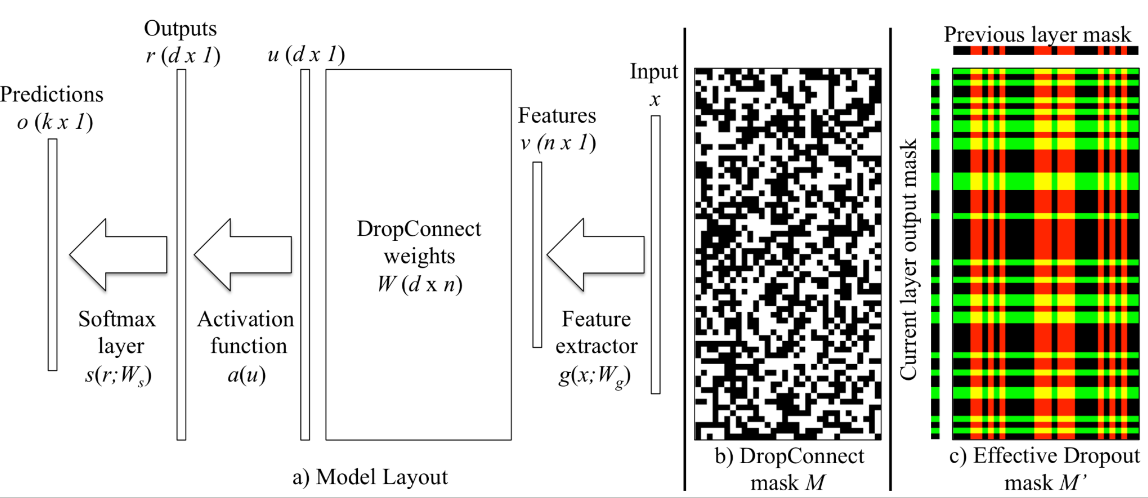

In [27]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):
        if self.training:
            mask = torch.empty_like(self.linear.weight).bernoulli_(1 - self.p)
            mask = mask / (1 - self.p)
            mask = torch.autograd.Variable(mask, requires_grad=False)
        else:
            mask = torch.ones_like(self.linear.weight)
            mask = torch.autograd.Variable(mask, requires_grad=False)
        mask = mask.data
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output

Основа для сети, которую будем обучать:

In [28]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()

        channels = 1

        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )

        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()

        self.final_part = final_part

        self.log_softmax = nn.LogSoftmax(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

Добавим несколько слоев в конец сети:

In [30]:
layers = [
    nn.Linear(196, 128),
    nn.ReLU(),
    DropConnect(128, 128),
    nn.ReLU(),
    DropConnect(128, 128),
    nn.Linear(128, 10)
]

In [31]:
network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

Обучим получившуюся сеть:

In [32]:
for epoch in range(10):
    network.train()
    for batch_idx, (images_train, labels_train) in enumerate(train_loader):
        optimizer.zero_grad()
        X = images_train.data
        y = labels_train.data
        output = network(X)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()
        train_loss_epoch += loss.item()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(X), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
    
    network.eval()
    losses = []
    for batch_idx, (images_test, labels_test) in enumerate(test_loader):
        X = images_test.data
        y = labels_test.data
        output = network(X)
        loss = loss_fn(output, y)

        losses.append(loss.item())
        val_loss_epoch += loss.item()

    print('Test Epoch: {}\tLoss: {:.6f}'.format(
            epoch, np.mean(losses)))


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.312624
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.927626
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.362843
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.214885
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.168860
Test Epoch: 0	Loss: 0.142448
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.266792
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.222140
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.328501
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.175570
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.158071
Test Epoch: 1	Loss: 0.097780
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.087869
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.152609
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.107347
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.064085
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.152160
Test Epoch: 2	Loss: 0.083574
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.197035
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.141218
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.060016
Train Epoch: 3 [38400/60000 (64%)


#### 2.2 Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и DropConnect вместо всех линейных слоев


In [56]:
def plot_losses(train_losses, val_losses, title):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].plot(train_losses, color='blue')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Train loss')
    axs[0].grid(True)

    axs[1].plot(val_losses, label='Val loss', color='red')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].set_title('Val loss')
    axs[1].grid(True)

    plt.title = title
    plt.tight_layout()
    plt.show()

Для того, чтобы корректно построить график лосса по эпохам, немного изменим код обучения:
1. Добавим списки для хранения значений лосса для трейна и валидации;
2. В ходе обучения суммируем значения по батчам и усредняем в конце эпохи

Рассмотрим случай свертки 128-128-10 (вход = 196) с ReLU и Dropout между слоями, dropout возьмем из nn

In [41]:
layers = [
    nn.Linear(196, 128),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(128, 10)
]

network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

In [42]:
train_losses = []
val_losses = []
for epoch in range(10):
    network.train()
    train_loss_epoch = 0
    for batch_idx, (images_train, labels_train) in enumerate(train_loader):
        optimizer.zero_grad()
        X = images_train.data
        y = labels_train.data
        output = network(X)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()
        train_loss_epoch += loss.item()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(X), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
    train_loss_epoch /= len(train_loader)
    train_losses.append(train_loss_epoch)
    
    network.eval()
    losses = []
    val_loss_epoch = 0
    for batch_idx, (images_test, labels_test) in enumerate(test_loader):
        X = images_test.data
        y = labels_test.data
        output = network(X)
        loss = loss_fn(output, y)

        losses.append(loss.item())
        val_loss_epoch += loss.item()

    val_loss_epoch /= len(test_loader)
    val_losses.append(val_loss_epoch)
    print('Test Epoch: {}\tLoss: {:.6f}'.format(
            epoch, np.mean(losses)))

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.302605
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.119149
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.491861
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.643576
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.432181
Test Epoch: 0	Loss: 0.205893
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.349492
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.284825
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.208059
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.252726
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.231594
Test Epoch: 1	Loss: 0.134695
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.204281
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.292652
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.193364
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.317819
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.274542
Test Epoch: 2	Loss: 0.113420
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.188791
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.220651
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.206668
Train Epoch: 3 [38400/60000 (64%)

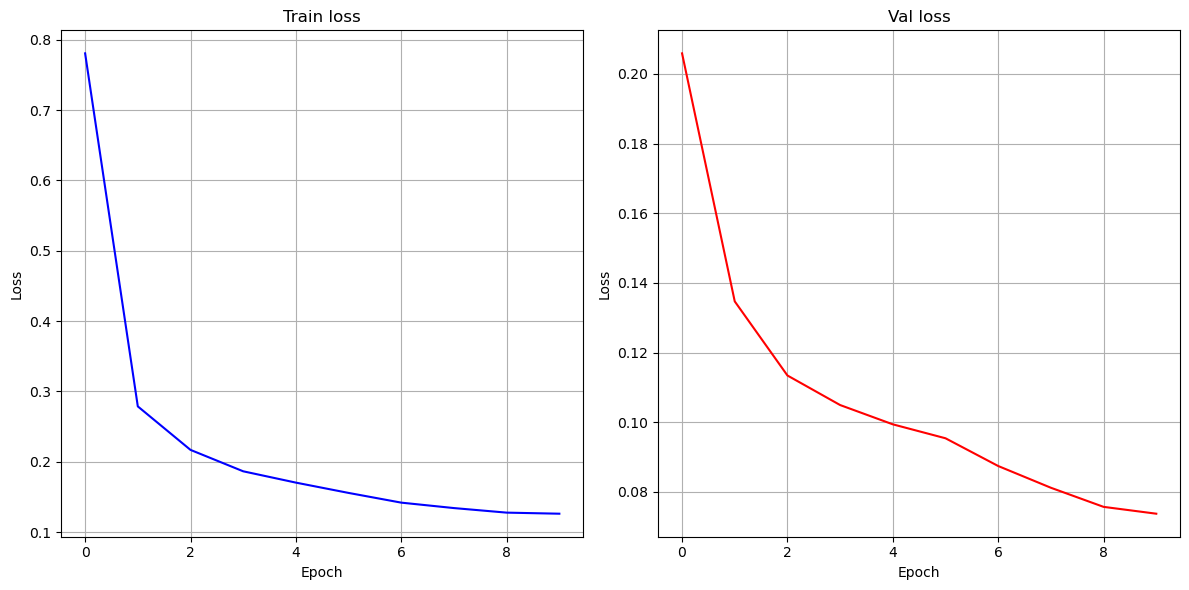

In [57]:
plot_losses(train_losses, val_losses, title='Dropout')

Как видно из графиков, значение лосса стабильно падает и на трейне и на валидации, теперь уберем Dropout и заменим все линейные слои на DropConnect

In [60]:
layers = [
    DropConnect(196, 128),
    nn.ReLU(),
    DropConnect(128, 128),
    nn.ReLU(),
    DropConnect(128, 10)
]

network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

In [61]:
train_losses = []
val_losses = []
for epoch in range(10):
    network.train()
    train_loss_epoch = 0
    for batch_idx, (images_train, labels_train) in enumerate(train_loader):
        optimizer.zero_grad()
        X = images_train.data
        y = labels_train.data
        output = network(X)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()
        train_loss_epoch += loss.item()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(X), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
    train_loss_epoch /= len(train_loader)
    train_losses.append(train_loss_epoch)
    
    network.eval()
    losses = []
    val_loss_epoch = 0
    for batch_idx, (images_test, labels_test) in enumerate(test_loader):
        X = images_test.data
        y = labels_test.data
        output = network(X)
        loss = loss_fn(output, y)

        losses.append(loss.item())
        val_loss_epoch += loss.item()

    val_loss_epoch /= len(test_loader)
    val_losses.append(val_loss_epoch)
    print('Test Epoch: {}\tLoss: {:.6f}'.format(
            epoch, np.mean(losses)))

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.332853
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.465322
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.278153
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.754641
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.640600
Test Epoch: 0	Loss: 0.320435
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.599362
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.367407
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.432386
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.282159
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.484558
Test Epoch: 1	Loss: 0.183664
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.422451
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.273492
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.275375
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.215388
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.385407
Test Epoch: 2	Loss: 0.145688
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.271863
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.301095
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.217355
Train Epoch: 3 [38400/60000 (64%)

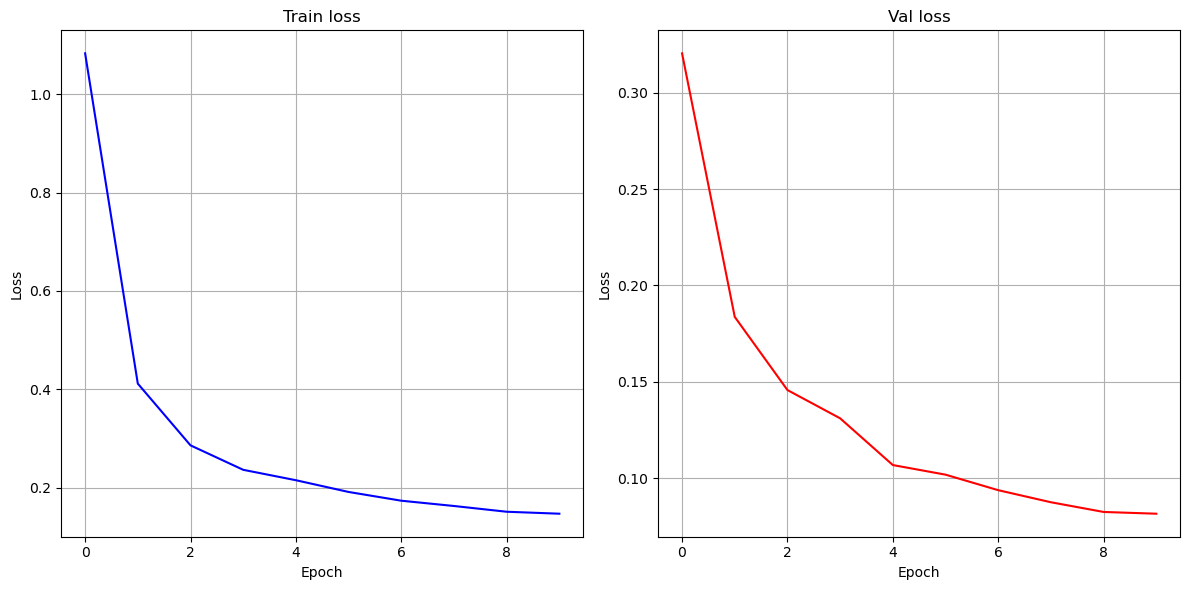

In [62]:
plot_losses(train_losses, val_losses, title='DropConnect')

Можно сделать вывод что и Dropout и DropConnect примерно в равной степени хорошо работают в данном случае, небольшое отличие в том, что стартовые значения на 1 эпохе несколько выше у DropConnect, чем у Dropout, но по итогу это не сказывается на финальном качестве обучения.

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

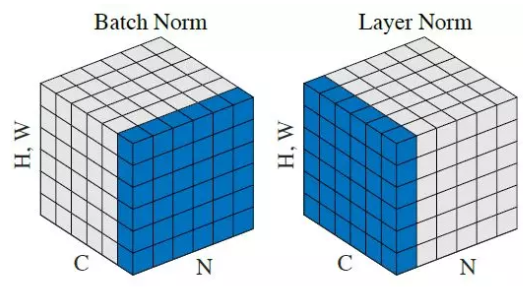

#### 3.1 Реализуйте Layer Normalization **(1 балл)**

In [63]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)
        eps = 1e-9
        
        output = (x - mean) / (std + eps)
        return output

#### 3.2 Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями

In [67]:
layers = [
    nn.Linear(196, 128),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Linear(128, 10)
]

network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

In [68]:
train_losses = []
val_losses = []
for epoch in range(10):
    network.train()
    train_loss_epoch = 0
    for batch_idx, (images_train, labels_train) in enumerate(train_loader):
        optimizer.zero_grad()
        X = images_train.data
        y = labels_train.data
        output = network(X)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()
        train_loss_epoch += loss.item()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(X), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
    train_loss_epoch /= len(train_loader)
    train_losses.append(train_loss_epoch)
    
    network.eval()
    losses = []
    val_loss_epoch = 0
    for batch_idx, (images_test, labels_test) in enumerate(test_loader):
        X = images_test.data
        y = labels_test.data
        output = network(X)
        loss = loss_fn(output, y)

        losses.append(loss.item())
        val_loss_epoch += loss.item()

    val_loss_epoch /= len(test_loader)
    val_losses.append(val_loss_epoch)
    print('Test Epoch: {}\tLoss: {:.6f}'.format(
            epoch, np.mean(losses)))

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.534616
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.210699
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.180886
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.227118
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.130243
Test Epoch: 0	Loss: 0.121998
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.091192
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.122460
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.084826
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.086281
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.153035
Test Epoch: 1	Loss: 0.098170
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.082715
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.075339
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.060672
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.027925
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.092366
Test Epoch: 2	Loss: 0.072466
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.042237
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.044121
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.106574
Train Epoch: 3 [38400/60000 (64%)

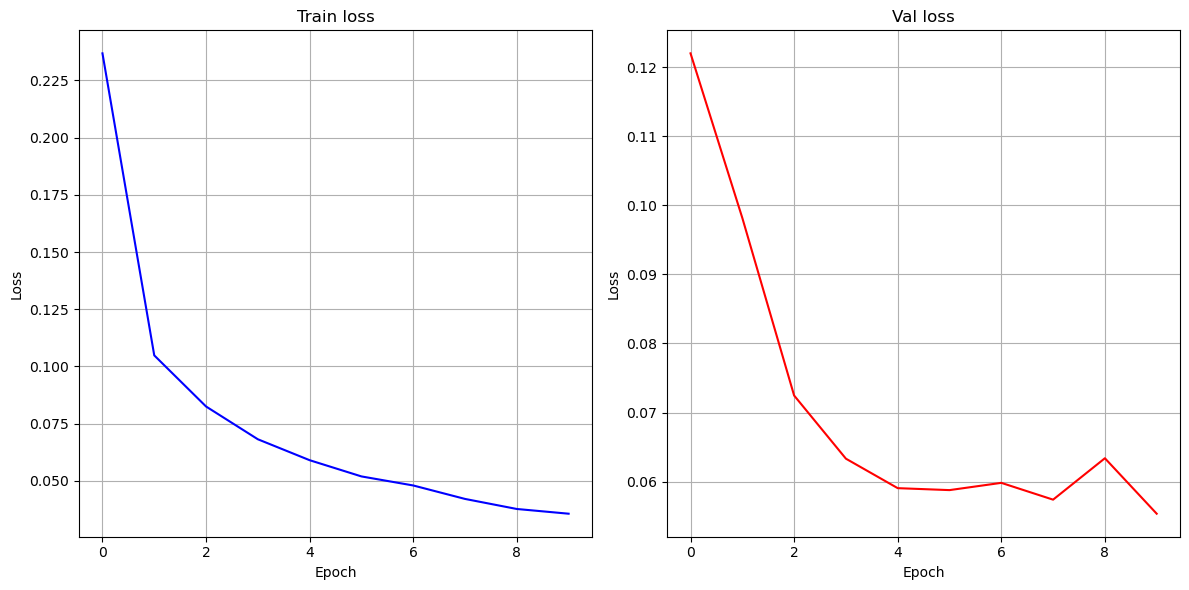

In [69]:
plot_losses(train_losses, val_losses, title='Batch Norm')

В целом все хорошо, но есть небольшой скачок на графике валидации на предпоследней эпохе, при этом на 10 эпохе лосс все равно упал

In [72]:
layers = [
    nn.Linear(196, 128),
    nn.ReLU(),
    LayerNormalization(),
    nn.Linear(128, 128),
    nn.ReLU(),
    LayerNormalization(),
    nn.Linear(128, 10)
]

network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

In [73]:
train_losses = []
val_losses = []
for epoch in range(10):
    network.train()
    train_loss_epoch = 0
    for batch_idx, (images_train, labels_train) in enumerate(train_loader):
        optimizer.zero_grad()
        X = images_train.data
        y = labels_train.data
        output = network(X)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()
        train_loss_epoch += loss.item()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(X), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
    train_loss_epoch /= len(train_loader)
    train_losses.append(train_loss_epoch)
    
    network.eval()
    losses = []
    val_loss_epoch = 0
    for batch_idx, (images_test, labels_test) in enumerate(test_loader):
        X = images_test.data
        y = labels_test.data
        output = network(X)
        loss = loss_fn(output, y)

        losses.append(loss.item())
        val_loss_epoch += loss.item()

    val_loss_epoch /= len(test_loader)
    val_losses.append(val_loss_epoch)
    print('Test Epoch: {}\tLoss: {:.6f}'.format(
            epoch, np.mean(losses)))

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.413081
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.253037
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.214233
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.165705
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.075424
Test Epoch: 0	Loss: 0.109424
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.131472
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.062088
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.096731
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.096171
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.161131
Test Epoch: 1	Loss: 0.079286
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.049886
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.099197
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.131512
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.050064
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.113993
Test Epoch: 2	Loss: 0.077162
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.056183
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.069592
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.035889
Train Epoch: 3 [38400/60000 (64%)

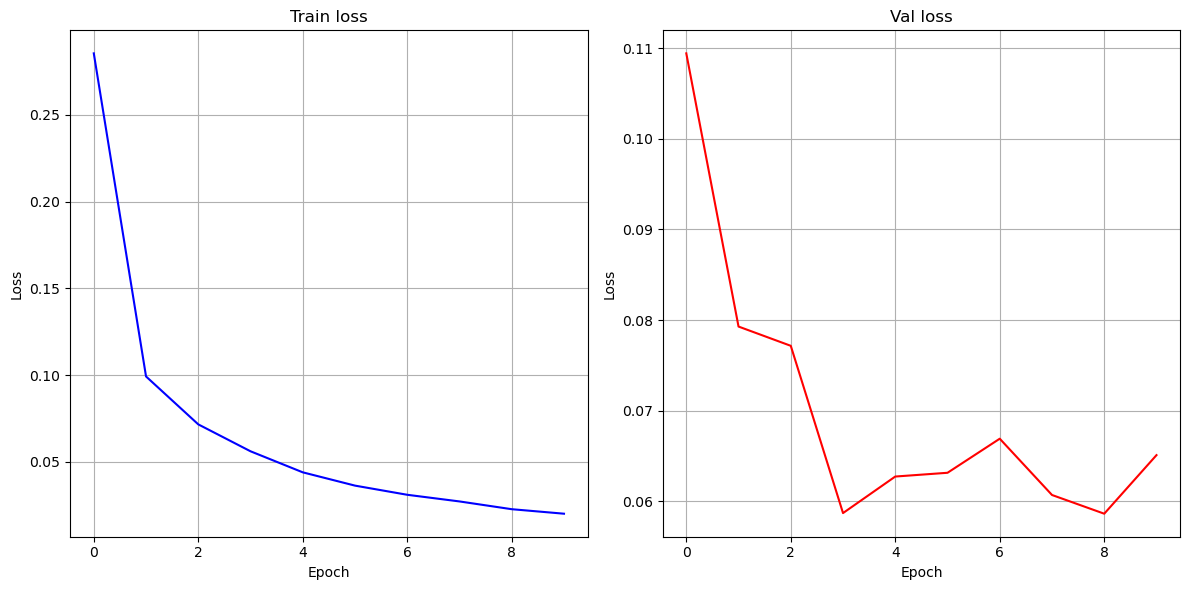

In [74]:
plot_losses(train_losses, val_losses, title='Layer Norm')

В случае Layer Normalization график на валидации получается ломанный, при этом значения лосса ~нормальные. Можно сделать вывод, что процесс обучения с Layer Normalization менее комфортный, но результаты согласуются